In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import wrn_28_2
import torch
from tqdm import tqdm
import torch.nn.functional as F
from ema import EMA,EMADriver, set_ema_model
from train import trainer
from eval import predict, eval
from tqdm import tqdm
from semilearn import get_dataset, get_data_loader, get_net_builder, get_algorithm, get_config, Trainer
# from semilearn.datasets.cv_datasets import get_cifar
from data import get_cifar2
import argparse
from semilearn.core.utils import get_dataset, get_data_loader, get_optimizer, get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
from flexmatch import FlexMatch2

/opt/conda/envs/usb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
device = torch.device('cuda:0')

m = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
_=m.to(device)
ema = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
ema = set_ema_model(ema, m)
emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
emaA.before_run()
NUM_CLASSES=10
args_d = {'dataset': 'cifar10',
         'num_classes': NUM_CLASSES,
         'train_sampler': 'RandomSampler',
         'num_workers': 0,
         'lb_imb_ratio': 1,
         'ulb_imb_ratio':1.0,
          'batch_size': 32,
         'ulb_num_labels': 150,
         'img_size': 32,
         'crop_ratio': 0.875,
         'num_labels': 30,
         'seed': 1,
         'epoch': 3,
         'num_train_iter':150,
         'net': 'wrn_28_8',
         'optim': 'SGD',
         'lr': 0.03,
         'momentum': 0.9,
         'weight_decay': 0.0005,
         'layer_decay': 0.75,
          'num_warmup_iter': 0,
         'algorithm': None,
         'data_dir': './data',
         'uratio': 3,
         'eval_batch_size': 64}

parser = argparse.ArgumentParser(description='Semi-Supervised Learning (USB semilearn package)')
args = parser.parse_args("")
# args
for k in args_d:
        setattr(args, k, args_d[k])
# lb_dset, ulb_dset, eval_dset = get_cifar(args,
#           alg=None, 
#           name='cifar10',
#           num_labels=4000,
#           num_classes=10,
#           data_dir='./data',
#           include_lb_to_ulb=True)
# dataset_dict = get_dataset(args, 
#                            args.algorithm, 
#                            args.dataset, 
#                            args.num_labels, 
#                            args.num_classes, 
#                            data_dir=args.data_dir,
#                           include_lb_to_ulb=False)
dset, eval_dset =  get_cifar2(args, None, 'cifar10', args.num_labels, args.num_classes, data_dir='./data', include_lb_to_ulb=True)

train_lb_ulb_loader = get_data_loader(args, dset, args.batch_size)
# train_lb_loader = get_data_loader(args, dataset_dict['train_lb'], args.batch_size)
# train_ulb_loader = get_data_loader(args, dataset_dict['train_ulb'], int(args.batch_size * args.uratio))
eval_loader = get_data_loader(args, eval_dset, args.eval_batch_size)

optimizer = get_optimizer(m, args.optim, args.lr, args.momentum, args.weight_decay, args.layer_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            args.num_train_iter,
                                            num_warmup_steps=args.num_warmup_iter)
loss_ce = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
lb count: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
ulb count: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
1-self.alg:  None
Files already downloaded and verified


In [25]:
dset.ulb_data.shape

(180, 32, 32, 3)

In [26]:
'''
Question, How does training and dataloaders occur when the labeled dataloader finishes, does it loop over and restart
like the moduloud operator N%len(), try that!
'''

'\nQuestion, How does training and dataloaders occur when the labeled dataloader finishes, does it loop over and restart\nlike the moduloud operator N%len(), try that!\n'

In [27]:
# f = FlexMatch(T, 
#              p_cutoff, 
#              ulb_dest_len=len(dataset_dict['train_ulb']),
#              num_classes=10,
#              model=m)

# m = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
# _=m.to(device)
# ema = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
# ema = set_ema_model(ema, m)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA.before_run()

f = FlexMatch2(T=1.0, 
             p_cutoff=0.95, 
             ulb_dest_len=len(dset),
             num_classes=NUM_CLASSES,
             model=m,
             ema_model=ema,
             loss_ce=loss_ce,
             scheduler=scheduler,
             optimizer=optimizer,
             device=device,
             train_lb_ulb_loader=train_lb_ulb_loader,
             ulb_loss_ratio=1.0,
             hard_label=True, 
             thresh_warmup=True)

In [ ]:
steps, sup_loss,unsup_loss,total_loss, mask_ratio = f.fit(epochs=10)

 30%|███       | 3/10 [00:37<01:26, 12.40s/it]

In [ ]:
# mask_ratio

In [ ]:
# !nvidia-smi

In [ ]:
plt.plot(steps,sup_loss)
plt.plot(steps,unsup_loss)
plt.plot(steps,total_loss)
plt.plot(steps,mask_ratio)
#mask_ratio
plt.legend(['sup_loss','unsup_loss','total_loss','mask_ratio'])
plt.show()

100%|██████████| 50/50 [00:02<00:00, 24.65it/s]
/opt/conda/envs/usb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


top1 0.1740625 0.1328125


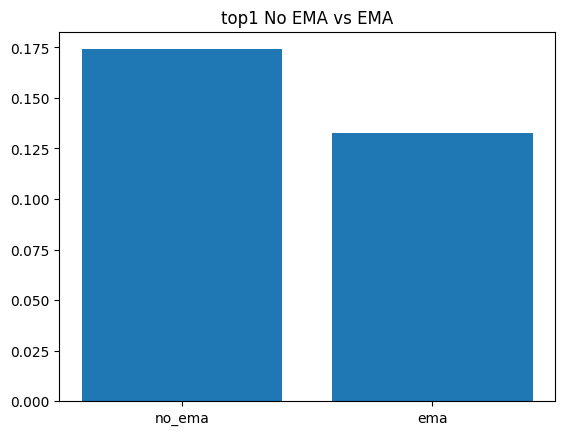

balanced_top1 0.17216412294329286 0.1327547024022489


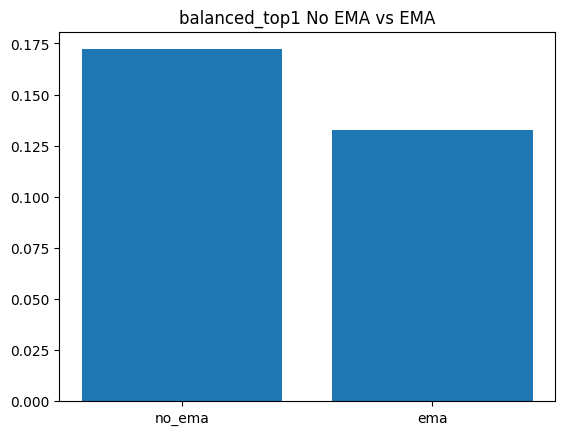

precision 0.16722307311238074 0.078543967679686


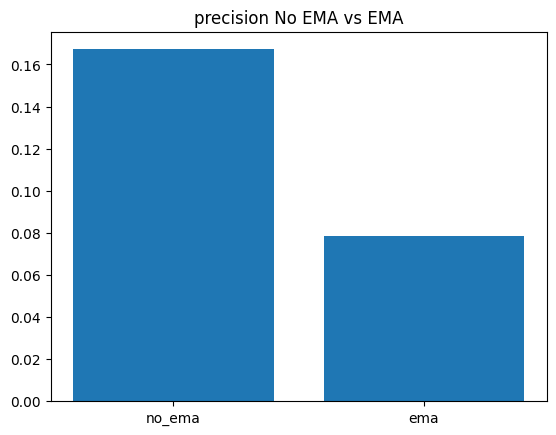

recall 0.17216412294329286 0.1327547024022489


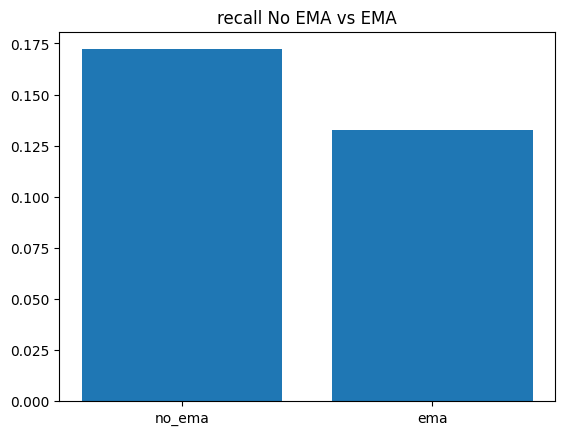

F1 0.15409226814283017 0.07833870511126795


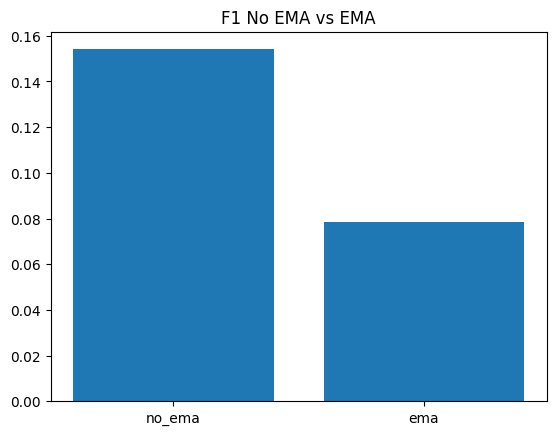

In [9]:
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=False)
no_ema = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=True)
ema_res = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}
for k in ema_res.keys():
    if k!='cf_mat':
        print(k,no_ema[k],ema_res[k])
        plt.bar(['no_ema','ema'],[no_ema[k],ema_res[k]])
        plt.title("{} No EMA vs EMA".format(k))
        plt.show()